# Text Classification #

### 20newsgroups dataset ###
20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
import gc
import numpy as np
np.set_printoptions(precision=2)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import pickle

train = fetch_20newsgroups(subset='train', shuffle=True)
train.target_names #prints all the categories

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [2]:
print('Train set size: %s ' % train.target.size)

Train set size: 11314 


In [3]:
print('FIRST TEXT CATEGORY: %s \n\n' % train.target_names[train.target[0]])
print('FIRST TEXT: \n')
print('\n'.join(train.data[0].split("\n")[:10])) 

FIRST TEXT CATEGORY: rec.autos 


FIRST TEXT: 

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 


In [4]:
train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

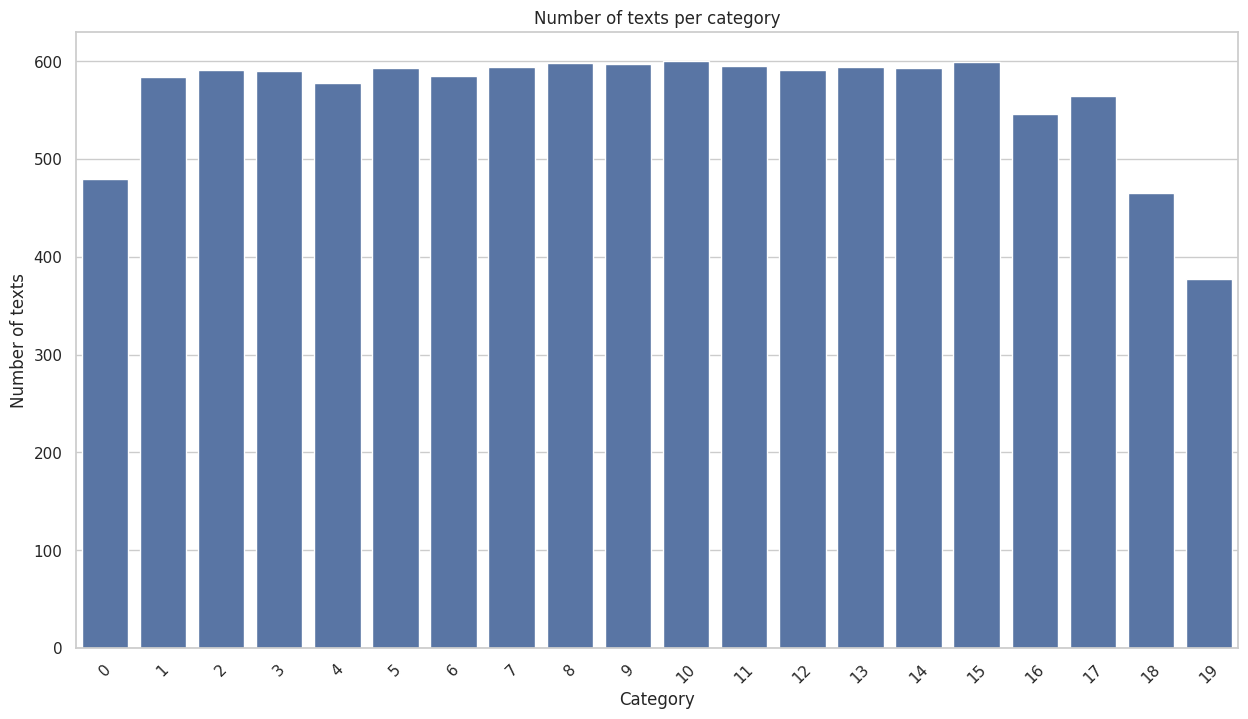

In [5]:
# plot count per category


sns.set_theme(style="whitegrid")


plt.figure(figsize=(15,8))

sns.countplot(x=train.target)

plt.title('Number of texts per category')

plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Number of texts')

plt.show()

# 1. Bag of Words  - data representation #

### Vectorization ###

In [6]:
corpus = [
    'aaa aaa aaa aaa aaa bbb',
    'bbb bbb bbb bbb bbb bbb',
    'bbb ccc',
   ]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out())
X.toarray()

['aaa' 'bbb' 'ccc']


array([[5, 1, 0],
       [0, 6, 0],
       [0, 1, 1]])

### TF-IDF (TF – term frequency, IDF – inverse document frequency) ###

In [7]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X)
X_train_tfidf.toarray()

array([[0.99, 0.12, 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 0.51, 0.86]])

# 2. Fitting a model, Pipeline #

In [8]:
# Vectorization
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(train.data)
X_train_counts.shape

(11314, 130107)

In [9]:
# Converting to TF-IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(11314, 130107)

In [10]:
# Using DecisionTreeClassifier

# dtc = DecisionTreeClassifier().fit(X_train_tfidf, train.target)


### Pipeline ###

In [11]:
# We can write less code and do all of the above, by building a pipeline.
# The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary.
# The purpose of the pipeline is to assemble several steps that can be
# cross-validated together while setting different parameters.



pipe_clf = Pipeline([
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('dtc', DecisionTreeClassifier())
])

# Now we can use orginal dataset train.data
pipe_clf = pipe_clf.fit(train.data, train.target)

In [12]:
# Performance of DecisionTreeClassifier
test = fetch_20newsgroups(subset='test', shuffle=True)
predicted = pipe_clf.predict(test.data)
np.mean(predicted == test.target)

# is the result realy bad?

np.float64(0.5549654806160382)

### Grid search ###

In [13]:
# Create a list of parameters and their values to be checked.
# All the parameters name are of the form 'stepName__paramName'.
# E.g. 'vect__ngram_range': [(1, 1), (1, 2)]
# that means use unigram and bigrams and choose the one which is optimal.

parameters = {
    'vect__ngram_range': [(1, 1),(1, 2)],  
    'tfidf__use_idf': (True, False)
#     'dtc__max_depth': (20,40)
}

In [14]:
#BELOW COMMANDS ARE TIME EXPENSIVE!

# n_jobs=-1 means using all cores
# Perheps you may need to run "conda install -c anaconda joblib" 



# gs_clf = GridSearchCV(pipe_clf, parameters, n_jobs=-1, verbose=10)

# # Run the grid search on the pipeline
# gs_clf = gs_clf.fit(train.data, train.target)
# print("Best score: %s" % gs_clf.best_score_) 
# print("Best param: %s" % gs_clf.best_params_) 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START tfidf__use_idf=True, vect__ngram_range=(1, 1)...............
[CV 2/5; 1/4] START tfidf__use_idf=True, vect__ngram_range=(1, 1)...............
[CV 3/5; 1/4] START tfidf__use_idf=True, vect__ngram_range=(1, 1)...............
[CV 4/5; 1/4] START tfidf__use_idf=True, vect__ngram_range=(1, 1)...............
[CV 5/5; 1/4] START tfidf__use_idf=True, vect__ngram_range=(1, 1)...............
[CV 1/5; 2/4] START tfidf__use_idf=True, vect__ngram_range=(1, 2)...............
[CV 2/5; 2/4] START tfidf__use_idf=True, vect__ngram_range=(1, 2)...............
[CV 3/5; 2/4] START tfidf__use_idf=True, vect__ngram_range=(1, 2)...............
[CV 4/5; 2/4] START tfidf__use_idf=True, vect__ngram_range=(1, 2)...............
[CV 5/5; 2/4] START tfidf__use_idf=True, vect__ngram_range=(1, 2)...............
[CV 1/5; 3/4] START tfidf__use_idf=False, vect__ngram_range=(1, 1)..............
[CV 2/5; 3/4] START tfidf__use_idf=False, vect__n

KeyboardInterrupt: 

# 3. NLTK - Natural Language Toolkit #

### Stop words ###

In [15]:
# # Removing stop words with CountVectorizer
# text_clf = Pipeline([
#     ('vect', CountVectorizer(stop_words='english')), 
#     ('tfidf', TfidfTransformer()), 
#     ('clf', DecisionTreeClassifier())
# ])

In [16]:
# !pip install nltk


nltk.download('snowball_data')
nltk.download('stopwords')


print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package snowball_data to
[nltk_data]     /home/kamil/nltk_data...
[nltk_data]   Package snowball_data is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kamil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Stemming ###

In [17]:

stemmer = SnowballStemmer("english", ignore_stopwords=True)
print('running --> %s' % stemmer.stem("running"))
print('generously --> %s' %stemmer.stem("generously"))

running --> run
generously --> generous


In [18]:
# Use stemming in the vectorization process

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

# pipe_stemmed = Pipeline([
#     ('vect', stemmed_count_vect),
#     ('tfidf', TfidfTransformer()), 
#     ('dtc', DecisionTreeClassifier())
# ])

# pipe_stemmed = pipe_stemmed.fit(train.data, train.target)

# predicted_stemmed = pipe_stemmed.predict(test.data)

# print('Accuracy after stemming: %s' % np.mean(predicted_stemmed == test.target))

In [19]:
# decission_tree_pipe = Pipeline(
#     [
#         ("vect", stemmed_count_vect),
#         ("tfidf", TfidfTransformer()),
#         ("dtc", DecisionTreeClassifier()),
#     ]
# )

# parameters = {
#     "dtc__max_depth": [None, 20, 30, 40, 50],
#     "dtc__min_samples_split": (2, 3),
#     "dtc__class_weight": (None, "balanced")
# }

# decision_tree = GridSearchCV(decission_tree_pipe, parameters, n_jobs=-1, verbose=10, scoring='accuracy')

# # Run the grid search on the pipeline
# decision_tree = decision_tree.fit(train.data, train.target)
# print("Best score: %s" % decision_tree.best_score_)
# print("Best param: %s" % decision_tree.best_params_)

# # save the model to disk

# filename = 'finalized_decison_tree.sav'
# pickle.dump(decision_tree, open(filename, 'wb'))

In [20]:
def train_model(pipe, params, train, name):
    model = GridSearchCV(pipe, params, n_jobs=-1, verbose=10, scoring="accuracy")

    # Run the grid search on the pipeline
    model = model.fit(train.data, train.target)
    print("Model: %s" % name)
    print("Best score: %s" % model.best_score_)
    print("Best param: %s" % model.best_params_)

    # save the model to disk

    filename = "finalized_%s.sav" % name
    pickle.dump(model, open(filename, "wb"))



In [21]:
# gc.collect()

# random_forest_pipe = Pipeline(
#     [
#         ("vect", stemmed_count_vect),
#         ("tfidf", TfidfTransformer()),
#         ("rfc", RandomForestClassifier()),
#     ]
# )

# parameters = {
#     "vect__ngram_range": [(1, 1), (1, 2)],
#     "tfidf__use_idf": (True, False),
#     "rfc__n_estimators": [100, 200, 300],
#     "rfc__max_depth": [None, 20, 30],
#     "rfc__min_samples_split": (2, 3),
# }

# train_model(random_forest_pipe, parameters, train, "random_forest")

In [23]:
# from sklearn.neighbors import KNeighborsClassifier

# gc.collect()

# k_nearest_neighbours_pipe = Pipeline(
#     [
#         ("vect", stemmed_count_vect),
#         ("tfidf", TfidfTransformer()),
#         ("knn", KNeighborsClassifier()),
#     ]
# )

# parameters = {
#     "knn__n_neighbors": range(1, 10),
#     "knn__weights": ["uniform", "distance"],
# }

# train_model(k_nearest_neighbours_pipe, parameters, train, "k_nearest_neighbours")

In [24]:
# from sklearn.linear_model import LogisticRegression

# gc.collect()

# logistic_regression_pipe = Pipeline(
#     [
#         ("vect", stemmed_count_vect),
#         ("tfidf", TfidfTransformer()),
#         ("lr", LogisticRegression()),
#     ]
# )

# parameters = {
#     "lr__C": [0.001, 0.01, 0.1, 1, 10, 100],
#     "lr__penalty": ["l1", "l2"],
# }

# train_model(logistic_regression_pipe, parameters, train, "logistic_regression")

In [25]:
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# import keras

# gc.collect()

# callback = keras.callbacks.EarlyStopping(monitor='loss', patience=2)

# def create_model():
#     model = Sequential()
#     model.add(Dense(512, activation="relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(512, activation="relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(20, activation="softmax"))
#     model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
#     return model

# stemmed_count_vect = StemmedCountVectorizer(stop_words="english")

# train_stemed = stemmed_count_vect.fit_transform(train.data)
# train_tf = TfidfTransformer(use_idf=False).fit_transform(train_stemed)


# # train with kfolds cross validation
# from sklearn.model_selection import KFold
# from sklearn.metrics import accuracy_score

# kf = KFold(n_splits=5, shuffle=True)
# kf.get_n_splits(train_tf)

# acc_per_fold = []
# loss_per_fold = []

# fold_no = 1
# for train_index, test_index in kf.split(train_tf):
#     model = create_model()

#     X_train, X_test = train_tf[train_index], train_tf[test_index]
#     y_train, y_test = train.target[train_index], train.target[test_index]

#     history = model.fit(X_train.toarray(), y_train, epochs=10, batch_size=128, validation_data=(X_test.toarray(), y_test), callbacks=[callback])

#     scores = model.evaluate(X_test.toarray(), y_test, verbose=0)

#     print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
#     acc_per_fold.append(scores[1] * 100)
#     loss_per_fold.append(scores[0])

#     fold_no = fold_no + 1

# print("Average scores for all folds:")
# print(f"> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})")
# print(f"> Loss: {np.mean(loss_per_fold)}")

In [ ]:
from sklearn.svm import LinearSVC

gc.collect()

svc_pipe = Pipeline(
    [
        ("vect", stemmed_count_vect),
        ("tfidf", TfidfTransformer()),
        ("svc", LinearSVC()),
    ]
)

parameters = {
    "svc__max_iter": [1000, 3000, 5000],
    "svc__multi_class": ["ovr", "crammer_singer"],
    "svc__C": [0.1, 1, 10],

}

train_model(svc_pipe, parameters, train, "svc")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5; 1/18] START svc__C=0.1, svc__max_iter=1000, svc__multi_class=ovr.......
[CV 3/5; 1/18] START svc__C=0.1, svc__max_iter=1000, svc__multi_class=ovr.......
[CV 5/5; 1/18] START svc__C=0.1, svc__max_iter=1000, svc__multi_class=ovr.......
[CV 2/5; 1/18] START svc__C=0.1, svc__max_iter=1000, svc__multi_class=ovr.......
[CV 2/5; 2/18] START svc__C=0.1, svc__max_iter=1000, svc__multi_class=crammer_singer
[CV 1/5; 2/18] START svc__C=0.1, svc__max_iter=1000, svc__multi_class=crammer_singer
[CV 4/5; 1/18] START svc__C=0.1, svc__max_iter=1000, svc__multi_class=ovr.......
[CV 4/5; 2/18] START svc__C=0.1, svc__max_iter=1000, svc__multi_class=crammer_singer
[CV 3/5; 2/18] START svc__C=0.1, svc__max_iter=1000, svc__multi_class=crammer_singer
[CV 5/5; 2/18] START svc__C=0.1, svc__max_iter=1000, svc__multi_class=crammer_singer
[CV 1/5; 3/18] START svc__C=0.1, svc__max_iter=3000, svc__multi_class=ovr.......
[CV 2/5; 3/18] START svc__C=

/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 2/18] END svc__C=0.1, svc__max_iter=1000, svc__multi_class=crammer_singer;, score=0.888 total time= 1.8min
[CV 5/5; 4/18] START svc__C=0.1, svc__max_iter=3000, svc__multi_class=crammer_singer


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 3/18] END svc__C=0.1, svc__max_iter=3000, svc__multi_class=ovr;, score=0.900 total time=  51.6s
[CV 1/5; 5/18] START svc__C=0.1, svc__max_iter=5000, svc__multi_class=ovr.......
[CV 3/5; 2/18] END svc__C=0.1, svc__max_iter=1000, svc__multi_class=crammer_singer;, score=0.887 total time= 1.9min
[CV 2/5; 5/18] START svc__C=0.1, svc__max_iter=5000, svc__multi_class=ovr.......
[CV 1/5; 2/18] END svc__C=0.1, svc__max_iter=1000, svc__multi_class=crammer_singer;, score=0.891 total time= 1.9min
[CV 3/5; 5/18] START svc__C=0.1, svc__max_iter=5000, svc__multi_class=ovr.......
[CV 4/5; 2/18] END svc__C=0.1, svc__max_iter=1000, svc__multi_class=crammer_singer;, score=0.890 total time= 2.0min
[CV 4/5; 5/18] START svc__C=0.1, svc__max_iter=5000, svc__multi_class=ovr.......
[CV 5/5; 2/18] END svc__C=0.1, svc__max_iter=1000, svc__multi_class=crammer_singer;, score=0.897 total time= 2.0min
[CV 5/5; 5/18] START svc__C=0.1, svc__max_iter=5000, svc__multi_class=ovr.......
[CV 5/5; 3/18] END svc__C=

/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 5/18] END svc__C=0.1, svc__max_iter=5000, svc__multi_class=ovr;, score=0.900 total time=  54.1s
[CV 3/5; 6/18] START svc__C=0.1, svc__max_iter=5000, svc__multi_class=crammer_singer
[CV 3/5; 5/18] END svc__C=0.1, svc__max_iter=5000, svc__multi_class=ovr;, score=0.900 total time=  53.3s
[CV 4/5; 6/18] START svc__C=0.1, svc__max_iter=5000, svc__multi_class=crammer_singer


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 4/18] END svc__C=0.1, svc__max_iter=3000, svc__multi_class=crammer_singer;, score=0.887 total time= 1.7min
[CV 5/5; 6/18] START svc__C=0.1, svc__max_iter=5000, svc__multi_class=crammer_singer
[CV 1/5; 4/18] END svc__C=0.1, svc__max_iter=3000, svc__multi_class=crammer_singer;, score=0.891 total time= 1.8min
[CV 1/5; 7/18] START svc__C=1, svc__max_iter=1000, svc__multi_class=ovr.........
[CV 2/5; 5/18] END svc__C=0.1, svc__max_iter=5000, svc__multi_class=ovr;, score=0.904 total time= 1.1min
[CV 2/5; 7/18] START svc__C=1, svc__max_iter=1000, svc__multi_class=ovr.........


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 4/18] END svc__C=0.1, svc__max_iter=3000, svc__multi_class=crammer_singer;, score=0.888 total time= 1.8min
[CV 3/5; 7/18] START svc__C=1, svc__max_iter=1000, svc__multi_class=ovr.........
[CV 4/5; 5/18] END svc__C=0.1, svc__max_iter=5000, svc__multi_class=ovr;, score=0.903 total time= 1.1min
[CV 4/5; 7/18] START svc__C=1, svc__max_iter=1000, svc__multi_class=ovr.........
[CV 5/5; 5/18] END svc__C=0.1, svc__max_iter=5000, svc__multi_class=ovr;, score=0.902 total time= 1.1min
[CV 5/5; 7/18] START svc__C=1, svc__max_iter=1000, svc__multi_class=ovr.........


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 4/18] END svc__C=0.1, svc__max_iter=3000, svc__multi_class=crammer_singer;, score=0.897 total time= 1.5min
[CV 1/5; 8/18] START svc__C=1, svc__max_iter=1000, svc__multi_class=crammer_singer
[CV 4/5; 4/18] END svc__C=0.1, svc__max_iter=3000, svc__multi_class=crammer_singer;, score=0.890 total time= 2.1min
[CV 2/5; 8/18] START svc__C=1, svc__max_iter=1000, svc__multi_class=crammer_singer


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 7/18] END svc__C=1, svc__max_iter=1000, svc__multi_class=ovr;, score=0.919 total time=  57.3s
[CV 3/5; 8/18] START svc__C=1, svc__max_iter=1000, svc__multi_class=crammer_singer


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 6/18] END svc__C=0.1, svc__max_iter=5000, svc__multi_class=crammer_singer;, score=0.891 total time= 1.8min
[CV 4/5; 8/18] START svc__C=1, svc__max_iter=1000, svc__multi_class=crammer_singer
[CV 3/5; 6/18] END svc__C=0.1, svc__max_iter=5000, svc__multi_class=crammer_singer;, score=0.887 total time= 1.3min
[CV 5/5; 8/18] START svc__C=1, svc__max_iter=1000, svc__multi_class=crammer_singer
[CV 2/5; 6/18] END svc__C=0.1, svc__max_iter=5000, svc__multi_class=crammer_singer;, score=0.888 total time= 1.9min
[CV 1/5; 9/18] START svc__C=1, svc__max_iter=3000, svc__multi_class=ovr.........
[CV 2/5; 7/18] END svc__C=1, svc__max_iter=1000, svc__multi_class=ovr;, score=0.921 total time= 1.2min
[CV 2/5; 9/18] START svc__C=1, svc__max_iter=3000, svc__multi_class=ovr.........
[CV 4/5; 7/18] END svc__C=1, svc__max_iter=1000, svc__multi_class=ovr;, score=0.922 total time= 1.1min
[CV 3/5; 9/18] START svc__C=1, svc__max_iter=3000, svc__multi_class=ovr.........
[CV 3/5; 7/18] END svc__C=1, svc__max

/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 6/18] END svc__C=0.1, svc__max_iter=5000, svc__multi_class=crammer_singer;, score=0.890 total time= 1.7min
[CV 1/5; 10/18] START svc__C=1, svc__max_iter=3000, svc__multi_class=crammer_singer


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 6/18] END svc__C=0.1, svc__max_iter=5000, svc__multi_class=crammer_singer;, score=0.897 total time= 1.8min
[CV 2/5; 10/18] START svc__C=1, svc__max_iter=3000, svc__multi_class=crammer_singer
[CV 1/5; 9/18] END svc__C=1, svc__max_iter=3000, svc__multi_class=ovr;, score=0.919 total time= 1.2min
[CV 3/5; 10/18] START svc__C=1, svc__max_iter=3000, svc__multi_class=crammer_singer
[CV 3/5; 9/18] END svc__C=1, svc__max_iter=3000, svc__multi_class=ovr;, score=0.923 total time= 1.2min
[CV 4/5; 10/18] START svc__C=1, svc__max_iter=3000, svc__multi_class=crammer_singer
[CV 2/5; 9/18] END svc__C=1, svc__max_iter=3000, svc__multi_class=ovr;, score=0.921 total time= 1.2min
[CV 5/5; 10/18] START svc__C=1, svc__max_iter=3000, svc__multi_class=crammer_singer
[CV 5/5; 9/18] END svc__C=1, svc__max_iter=3000, svc__multi_class=ovr;, score=0.927 total time= 1.2min
[CV 1/5; 11/18] START svc__C=1, svc__max_iter=5000, svc__multi_class=ovr........


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 9/18] END svc__C=1, svc__max_iter=3000, svc__multi_class=ovr;, score=0.922 total time= 1.2min
[CV 2/5; 11/18] START svc__C=1, svc__max_iter=5000, svc__multi_class=ovr........
[CV 1/5; 8/18] END svc__C=1, svc__max_iter=1000, svc__multi_class=crammer_singer;, score=0.920 total time= 2.4min
[CV 3/5; 11/18] START svc__C=1, svc__max_iter=5000, svc__multi_class=ovr........


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 8/18] END svc__C=1, svc__max_iter=1000, svc__multi_class=crammer_singer;, score=0.923 total time= 2.1min
[CV 4/5; 11/18] START svc__C=1, svc__max_iter=5000, svc__multi_class=ovr........


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 8/18] END svc__C=1, svc__max_iter=1000, svc__multi_class=crammer_singer;, score=0.924 total time= 2.1min
[CV 5/5; 11/18] START svc__C=1, svc__max_iter=5000, svc__multi_class=ovr........
[CV 1/5; 11/18] END svc__C=1, svc__max_iter=5000, svc__multi_class=ovr;, score=0.919 total time= 1.1min
[CV 3/5; 11/18] END svc__C=1, svc__max_iter=5000, svc__multi_class=ovr;, score=0.923 total time=  55.6s
[CV 1/5; 12/18] START svc__C=1, svc__max_iter=5000, svc__multi_class=crammer_singer
[CV 2/5; 12/18] START svc__C=1, svc__max_iter=5000, svc__multi_class=crammer_singer


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 11/18] END svc__C=1, svc__max_iter=5000, svc__multi_class=ovr;, score=0.921 total time= 1.2min
[CV 3/5; 12/18] START svc__C=1, svc__max_iter=5000, svc__multi_class=crammer_singer
[CV 2/5; 8/18] END svc__C=1, svc__max_iter=1000, svc__multi_class=crammer_singer;, score=0.924 total time= 3.5min
[CV 4/5; 12/18] START svc__C=1, svc__max_iter=5000, svc__multi_class=crammer_singer
[CV 4/5; 11/18] END svc__C=1, svc__max_iter=5000, svc__multi_class=ovr;, score=0.922 total time= 1.1min
[CV 5/5; 12/18] START svc__C=1, svc__max_iter=5000, svc__multi_class=crammer_singer


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 11/18] END svc__C=1, svc__max_iter=5000, svc__multi_class=ovr;, score=0.928 total time= 1.1min
[CV 1/5; 13/18] START svc__C=10, svc__max_iter=1000, svc__multi_class=ovr.......
[CV 1/5; 10/18] END svc__C=1, svc__max_iter=3000, svc__multi_class=crammer_singer;, score=0.920 total time= 2.9min
[CV 2/5; 13/18] START svc__C=10, svc__max_iter=1000, svc__multi_class=ovr.......


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 8/18] END svc__C=1, svc__max_iter=1000, svc__multi_class=crammer_singer;, score=0.923 total time= 3.9min
[CV 3/5; 13/18] START svc__C=10, svc__max_iter=1000, svc__multi_class=ovr.......


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 13/18] END svc__C=10, svc__max_iter=1000, svc__multi_class=ovr;, score=0.920 total time= 1.4min
[CV 4/5; 13/18] START svc__C=10, svc__max_iter=1000, svc__multi_class=ovr.......
[CV 3/5; 10/18] END svc__C=1, svc__max_iter=3000, svc__multi_class=crammer_singer;, score=0.923 total time= 3.5min
[CV 5/5; 13/18] START svc__C=10, svc__max_iter=1000, svc__multi_class=ovr.......
[CV 5/5; 10/18] END svc__C=1, svc__max_iter=3000, svc__multi_class=crammer_singer;, score=0.924 total time= 3.4min
[CV 1/5; 14/18] START svc__C=10, svc__max_iter=1000, svc__multi_class=crammer_singer
[CV 2/5; 10/18] END svc__C=1, svc__max_iter=3000, svc__multi_class=crammer_singer;, score=0.924 total time= 4.1min
[CV 2/5; 14/18] START svc__C=10, svc__max_iter=1000, svc__multi_class=crammer_singer
[CV 2/5; 13/18] END svc__C=10, svc__max_iter=1000, svc__multi_class=ovr;, score=0.920 total time= 1.6min
[CV 3/5; 14/18] START svc__C=10, svc__max_iter=1000, svc__multi_class=crammer_singer
[CV 3/5; 13/18] END svc__C=1

/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 10/18] END svc__C=1, svc__max_iter=3000, svc__multi_class=crammer_singer;, score=0.923 total time= 4.6min
[CV 5/5; 14/18] START svc__C=10, svc__max_iter=1000, svc__multi_class=crammer_singer


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 12/18] END svc__C=1, svc__max_iter=5000, svc__multi_class=crammer_singer;, score=0.924 total time= 3.0min
[CV 1/5; 15/18] START svc__C=10, svc__max_iter=3000, svc__multi_class=ovr.......
[CV 3/5; 12/18] END svc__C=1, svc__max_iter=5000, svc__multi_class=crammer_singer;, score=0.923 total time= 3.4min
[CV 2/5; 15/18] START svc__C=10, svc__max_iter=3000, svc__multi_class=ovr.......
[CV 4/5; 13/18] END svc__C=10, svc__max_iter=1000, svc__multi_class=ovr;, score=0.920 total time= 1.4min
[CV 3/5; 15/18] START svc__C=10, svc__max_iter=3000, svc__multi_class=ovr.......
[CV 1/5; 12/18] END svc__C=1, svc__max_iter=5000, svc__multi_class=crammer_singer;, score=0.920 total time= 3.7min
[CV 4/5; 15/18] START svc__C=10, svc__max_iter=3000, svc__multi_class=ovr.......
[CV 5/5; 13/18] END svc__C=10, svc__max_iter=1000, svc__multi_class=ovr;, score=0.925 total time= 1.6min
[CV 5/5; 15/18] START svc__C=10, svc__max_iter=3000, svc__multi_class=ovr.......


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 12/18] END svc__C=1, svc__max_iter=5000, svc__multi_class=crammer_singer;, score=0.923 total time= 3.8min
[CV 1/5; 16/18] START svc__C=10, svc__max_iter=3000, svc__multi_class=crammer_singer


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 12/18] END svc__C=1, svc__max_iter=5000, svc__multi_class=crammer_singer;, score=0.924 total time= 4.3min
[CV 2/5; 16/18] START svc__C=10, svc__max_iter=3000, svc__multi_class=crammer_singer


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 15/18] END svc__C=10, svc__max_iter=3000, svc__multi_class=ovr;, score=0.920 total time= 1.3min
[CV 3/5; 16/18] START svc__C=10, svc__max_iter=3000, svc__multi_class=crammer_singer
[CV 4/5; 14/18] END svc__C=10, svc__max_iter=1000, svc__multi_class=crammer_singer;, score=0.922 total time= 2.1min
[CV 4/5; 16/18] START svc__C=10, svc__max_iter=3000, svc__multi_class=crammer_singer
[CV 3/5; 15/18] END svc__C=10, svc__max_iter=3000, svc__multi_class=ovr;, score=0.920 total time= 1.3min
[CV 5/5; 16/18] START svc__C=10, svc__max_iter=3000, svc__multi_class=crammer_singer
[CV 4/5; 15/18] END svc__C=10, svc__max_iter=3000, svc__multi_class=ovr;, score=0.920 total time= 1.5min
[CV 1/5; 17/18] START svc__C=10, svc__max_iter=5000, svc__multi_class=ovr.......
[CV 2/5; 15/18] END svc__C=10, svc__max_iter=3000, svc__multi_class=ovr;, score=0.920 total time= 1.7min
[CV 2/5; 17/18] START svc__C=10, svc__max_iter=5000, svc__multi_class=ovr.......


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 15/18] END svc__C=10, svc__max_iter=3000, svc__multi_class=ovr;, score=0.925 total time= 1.6min
[CV 3/5; 17/18] START svc__C=10, svc__max_iter=5000, svc__multi_class=ovr.......


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 14/18] END svc__C=10, svc__max_iter=1000, svc__multi_class=crammer_singer;, score=0.918 total time= 3.3min
[CV 4/5; 17/18] START svc__C=10, svc__max_iter=5000, svc__multi_class=ovr.......
[CV 2/5; 14/18] END svc__C=10, svc__max_iter=1000, svc__multi_class=crammer_singer;, score=0.919 total time= 3.5min
[CV 5/5; 17/18] START svc__C=10, svc__max_iter=5000, svc__multi_class=ovr.......
[CV 1/5; 17/18] END svc__C=10, svc__max_iter=5000, svc__multi_class=ovr;, score=0.920 total time= 1.5min
[CV 1/5; 18/18] START svc__C=10, svc__max_iter=5000, svc__multi_class=crammer_singer
[CV 4/5; 17/18] END svc__C=10, svc__max_iter=5000, svc__multi_class=ovr;, score=0.920 total time= 1.5min
[CV 2/5; 18/18] START svc__C=10, svc__max_iter=5000, svc__multi_class=crammer_singer
[CV 2/5; 17/18] END svc__C=10, svc__max_iter=5000, svc__multi_class=ovr;, score=0.920 total time= 1.9min
[CV 3/5; 18/18] START svc__C=10, svc__max_iter=5000, svc__multi_class=crammer_singer
[CV 3/5; 17/18] END svc__C=10, svc__

/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 16/18] END svc__C=10, svc__max_iter=3000, svc__multi_class=crammer_singer;, score=0.918 total time= 3.5min
[CV 2/5; 16/18] END svc__C=10, svc__max_iter=3000, svc__multi_class=crammer_singer;, score=0.919 total time= 3.3min


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 14/18] END svc__C=10, svc__max_iter=1000, svc__multi_class=crammer_singer;, score=0.923 total time= 4.4min
[CV 3/5; 14/18] END svc__C=10, svc__max_iter=1000, svc__multi_class=crammer_singer;, score=0.918 total time= 5.5min


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 16/18] END svc__C=10, svc__max_iter=3000, svc__multi_class=crammer_singer;, score=0.923 total time= 3.3min


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 16/18] END svc__C=10, svc__max_iter=3000, svc__multi_class=crammer_singer;, score=0.918 total time= 4.2min
[CV 4/5; 18/18] END svc__C=10, svc__max_iter=5000, svc__multi_class=crammer_singer;, score=0.922 total time= 1.7min


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 16/18] END svc__C=10, svc__max_iter=3000, svc__multi_class=crammer_singer;, score=0.922 total time= 4.4min


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 18/18] END svc__C=10, svc__max_iter=5000, svc__multi_class=crammer_singer;, score=0.918 total time= 2.9min


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 18/18] END svc__C=10, svc__max_iter=5000, svc__multi_class=crammer_singer;, score=0.919 total time= 2.6min


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 18/18] END svc__C=10, svc__max_iter=5000, svc__multi_class=crammer_singer;, score=0.923 total time= 2.7min
[CV 3/5; 18/18] END svc__C=10, svc__max_iter=5000, svc__multi_class=crammer_singer;, score=0.918 total time= 2.9min
Model: svc
Best score: 0.9226623423051722
Best param: {'svc__C': 1, 'svc__max_iter': 1000, 'svc__multi_class': 'crammer_singer'}


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC

def test_model():
    np.random.seed(69)

    newsgroups = fetch_20newsgroups(subset="all")

    pipe = Pipeline(
        [
            ("vect", stemmed_count_vect),
            ("tfidf", TfidfTransformer()),
            ("svc", LinearSVC(max_iter=1000, multi_class="crammer_singer", C=1)),
        ]
    )

    cv_scores = cross_val_score(
        pipe, newsgroups.data, newsgroups.target, cv=5, scoring="accuracy"
    )

    pipe.fit(newsgroups.data, newsgroups.target)

    print("Cross validation scores: %s" % cv_scores)
    print("Mean: %s" % cv_scores.mean())
    print("Std: %s" % cv_scores.std())

In [38]:
test_model()


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Cross validation scores: [0.93 0.93 0.93 0.92 0.93]
Mean: 0.9307014433677502
Std: 0.003546013443436453


/home/kamil/miniconda3/envs/aad_2024/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
